### DESAFIO

### EDA

In [1]:
import pandas as pd
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import sweetviz as sv
# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score
# Otimização de Hiperparâmetros
import optuna

In [2]:
df_diabetes = pd.read_csv('./diabetes.csv')

In [3]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   glicemia          995 non-null    int64
 1   pressao_arterial  995 non-null    int64
 2   diabetes          995 non-null    int64
dtypes: int64(3)
memory usage: 23.4 KB


In [4]:
df_diabetes.describe()

,glicemia,pressao_arterial,diabetes
count,995.000000,995.000000,995.000000
mean,44.306533,79.184925,0.500503
std,6.707567,9.340204,0.500251
min,20.000000,50.000000,0.000000
25%,40.000000,72.000000,0.000000
50%,45.000000,80.000000,1.000000
75%,50.000000,87.000000,1.000000
max,70.000000,100.000000,1.000000


In [5]:
df_diabetes.head()

,glicemia,pressao_arterial,diabetes
0,40,85,0
1,40,92,0
2,45,63,1
3,45,80,0
4,40,73,1


In [13]:
px.bar(df_diabetes.value_counts('diabetes')/len(df_diabetes) * 100)

In [14]:
px.histogram(df_diabetes,x='pressao_arterial')

In [15]:
px.histogram(df_diabetes,x='glicemia')

In [18]:
px.box(df_diabetes,y='pressao_arterial')

In [19]:
px.box(df_diabetes,y='glicemia')

In [20]:
# Formulação de Hipótese
# A glicemia influencia em diabetes

df_diabetes['glicemia'].describe()

count    995.000000
mean      44.306533
std        6.707567
min       20.000000
25%       40.000000
50%       45.000000
75%       50.000000
max       70.000000
Name: glicemia, dtype: float64

In [24]:
# Bucketing glicemia
bins = [10,20,30,40,50,60,70]
bins_ordinal = [0,1,2,3,4,5]
labels_glicemia = ['10-20','20-30','30-40','40-50', '50-60', '60-70']
df_diabetes['Faixa_Glicemia_String'] = pd.cut(x=df_diabetes['glicemia'],bins=bins,labels=labels_glicemia, include_lowest=True)
df_diabetes['Faixa_Glicemia'] = pd.cut(x=df_diabetes['glicemia'],bins=bins,labels=bins_ordinal, include_lowest=True)
df_diabetes.head()

,glicemia,pressao_arterial,diabetes,Faixa_Glicemia_String,Faixa_Glicemia
0,40,85,0,30-40,2
1,40,92,0,30-40,2
2,45,63,1,40-50,3
3,45,80,0,40-50,3
4,40,73,1,30-40,2


In [28]:
# Criar uma Tabela de Contigência - Faixa Etária e Obesidade
tabela_contingencia_faixa_glicemia = sm.stats.Table.from_data(df_diabetes[['diabetes','Faixa_Glicemia_String']])

In [29]:
tabela_contingencia_faixa_glicemia.table_orig

Faixa_Glicemia_String,10-20,20-30,30-40,40-50,50-60,60-70
diabetes,,,,,,
0,0,0,165,330,2,0
1,3,37,167,197,84,10


In [ ]:
# Teste de Chi-Square de Pearson
# H0 as variáveis são independentes
# h1 as variáveis não são independentes
print(tabela_contingencia_faixa_glicemia.test_nominal_association())

df          5
pvalue      0.0
statistic   157.6709674647019


In [32]:
sv_diabetes_report = sv.analyze(df_diabetes,target_feat='diabetes')

                                             |          | [  0%]   00:00 -> (? left)


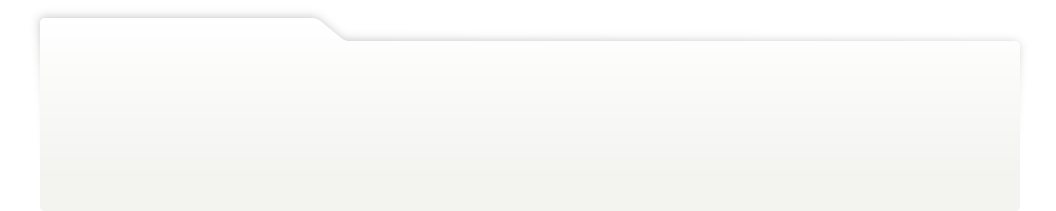
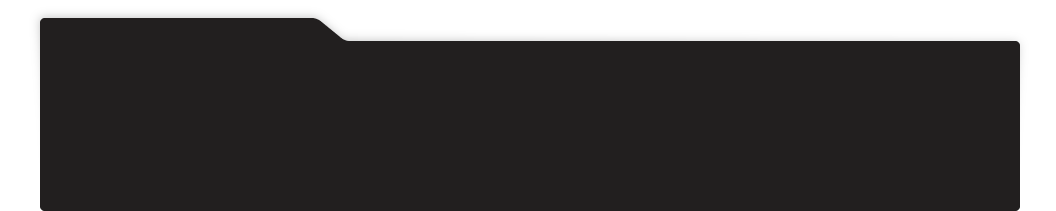
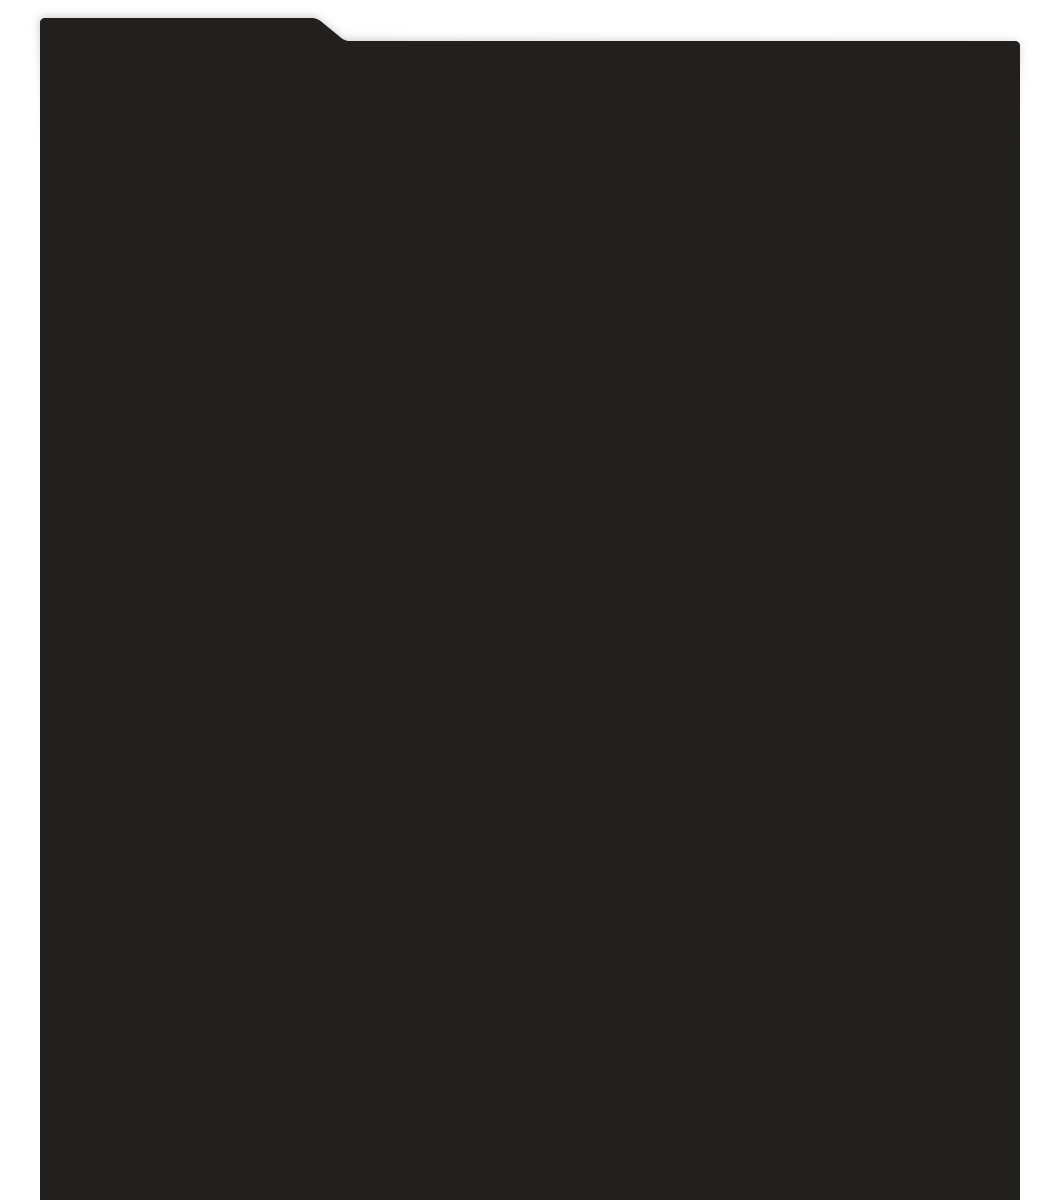
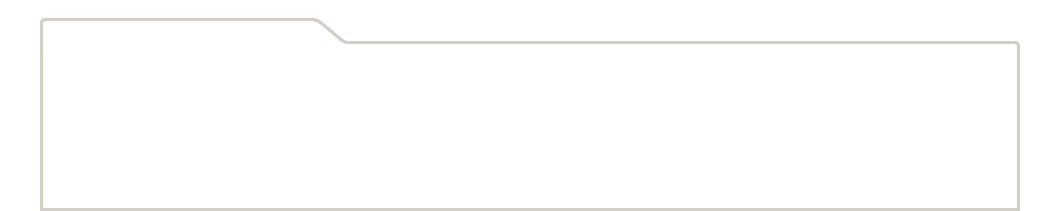
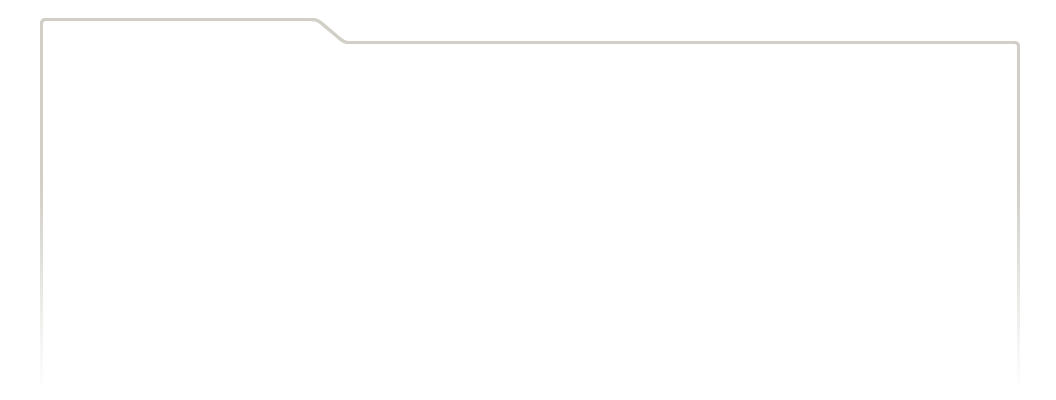
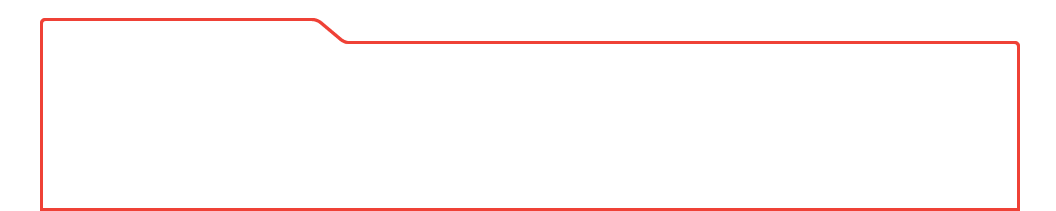
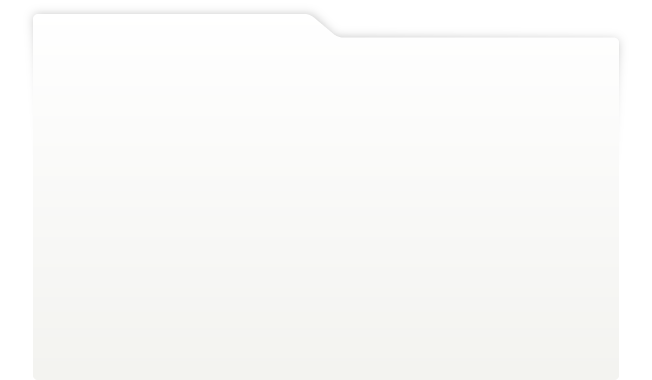
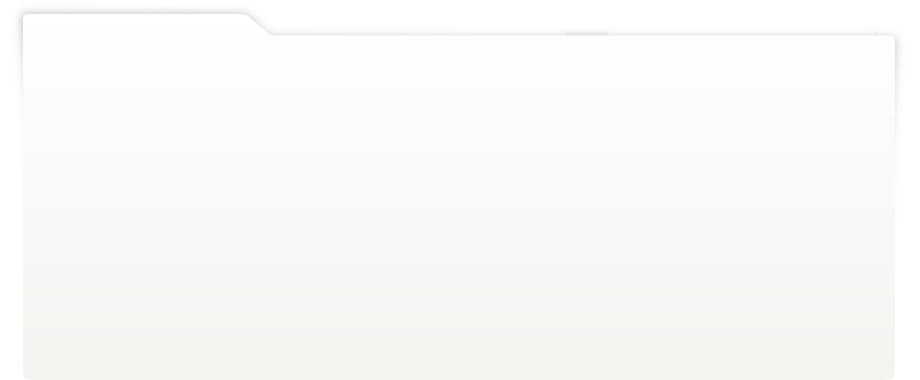
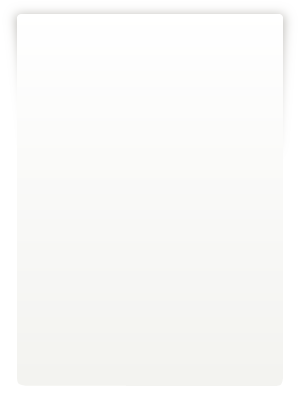
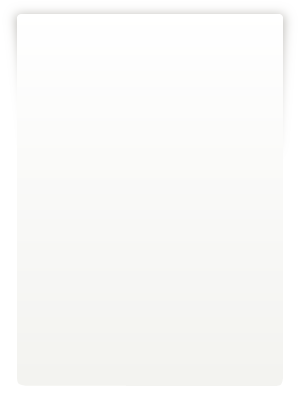
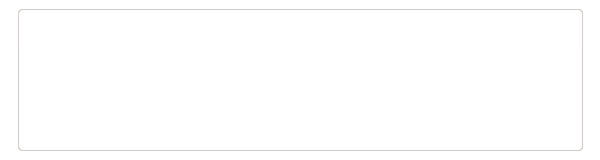
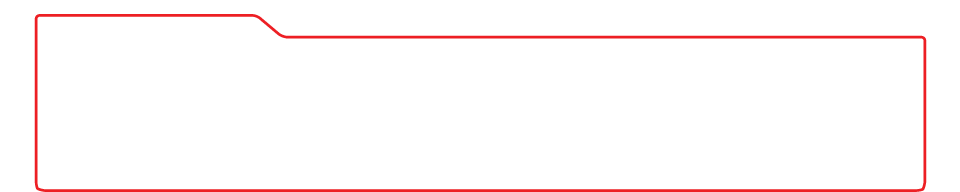
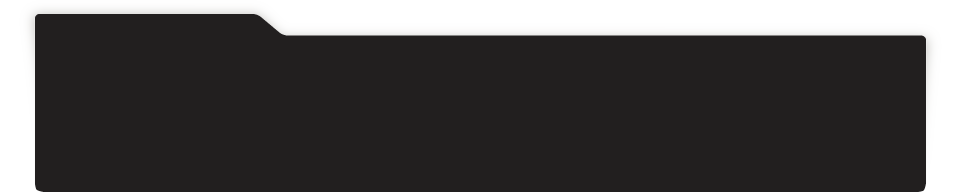
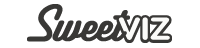
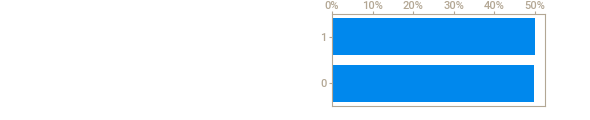
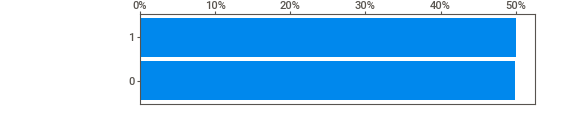
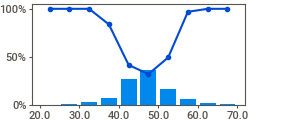
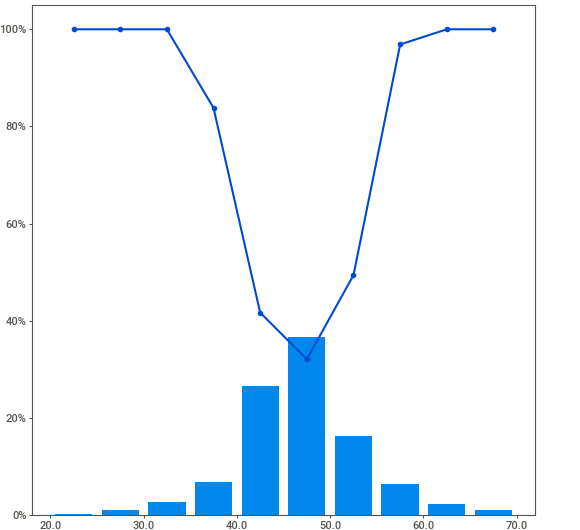
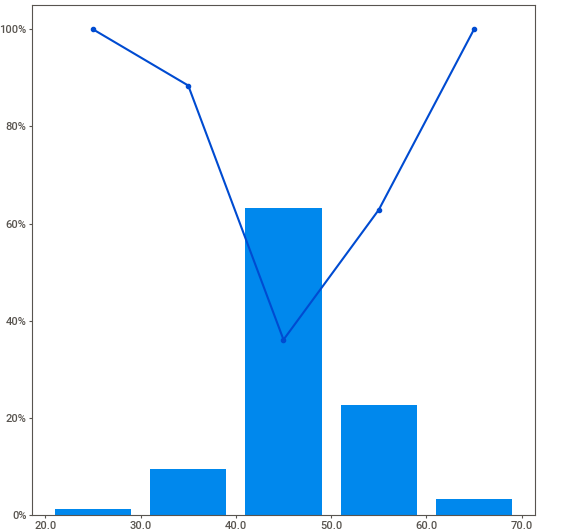
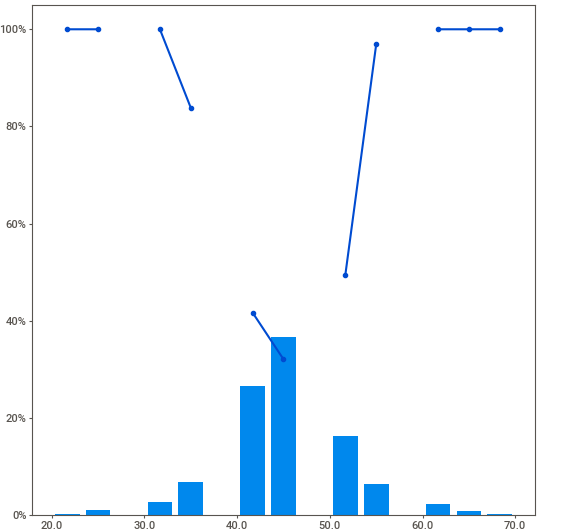
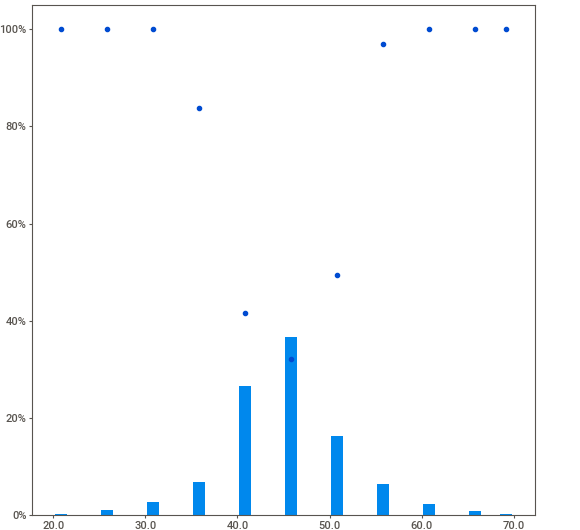
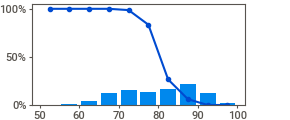
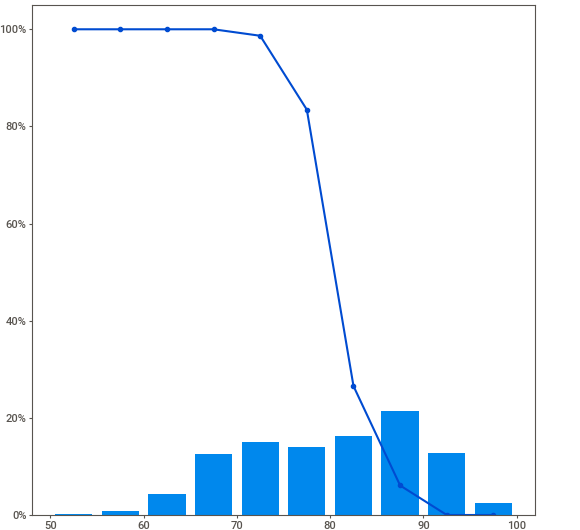
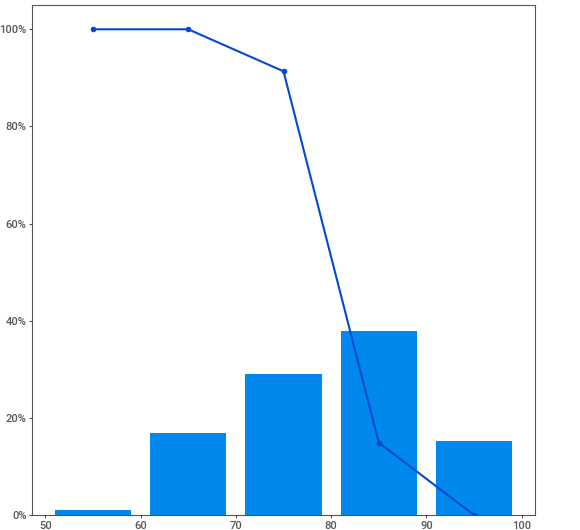
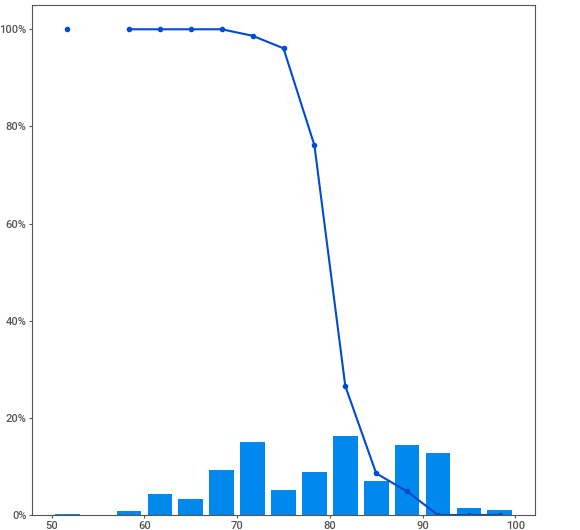
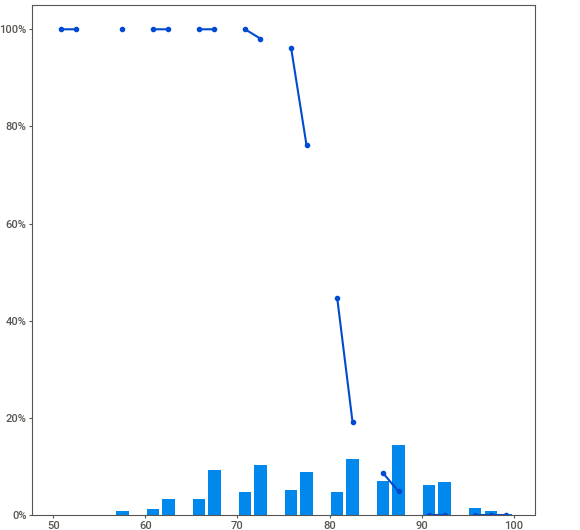
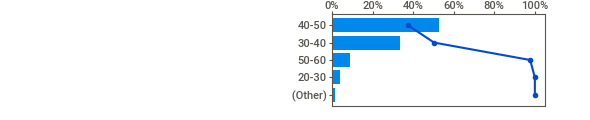
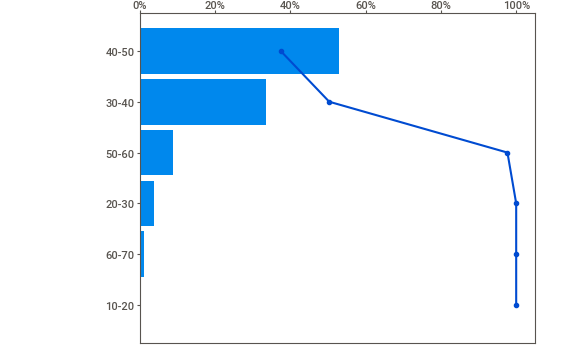
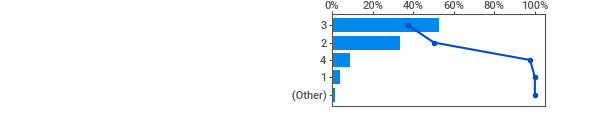
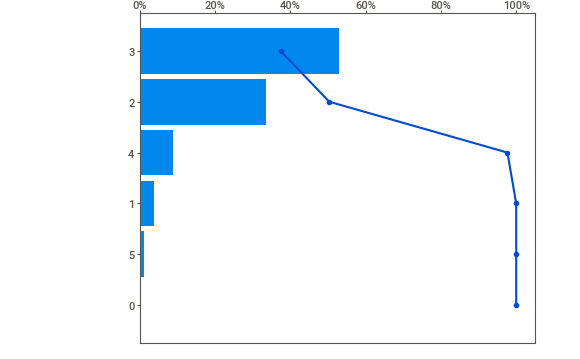
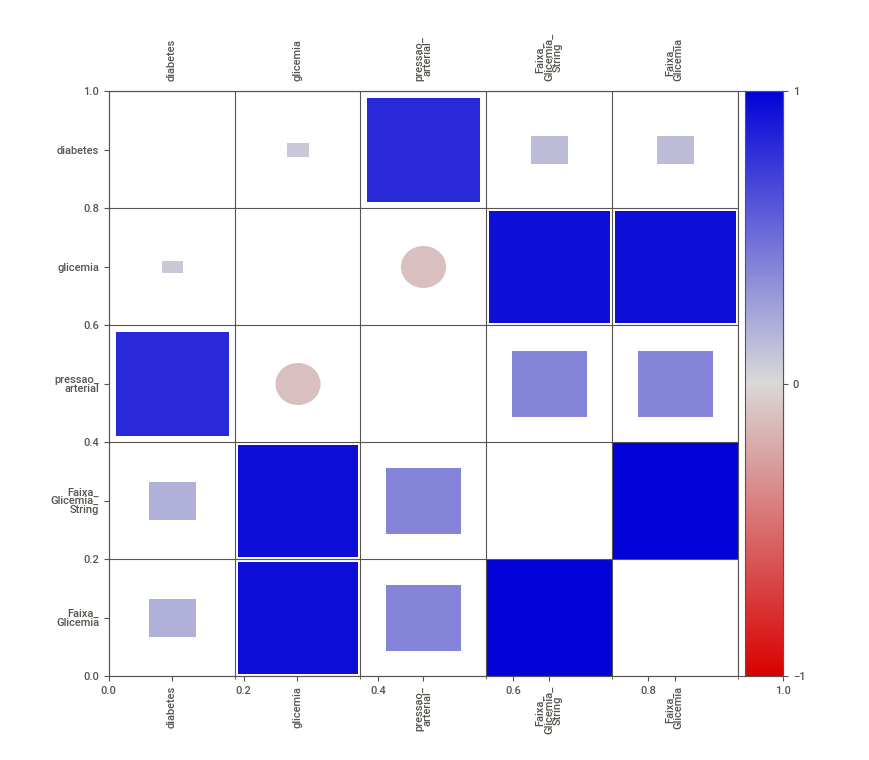
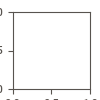

In [33]:
sv_diabetes_report.show_notebook()

## Treinamento do modelo - Baseline

In [45]:
X = df_diabetes.drop(columns=['diabetes','Faixa_Glicemia','Faixa_Glicemia_String'],axis=1)
y = df_diabetes['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)

In [46]:
model_baseline = GaussianNB()
model_baseline.fit(X_train,y_train)

,priors,None
,var_smoothing,1e-09


## Métricas do modelo baseline

In [47]:
y_pred = model_baseline.predict(X_test)

classification_report_str = classification_report(y_test,y_pred)
recall_baseline = recall_score(y_test,y_pred,average='macro')

print(f'Relatório de classificação: \n{classification_report_str}')
print(f'Recall:\n{recall_baseline}')

Relatório de classificação: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       140
           1       0.94      0.94      0.94       159

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299

Recall:
0.9328391734052112


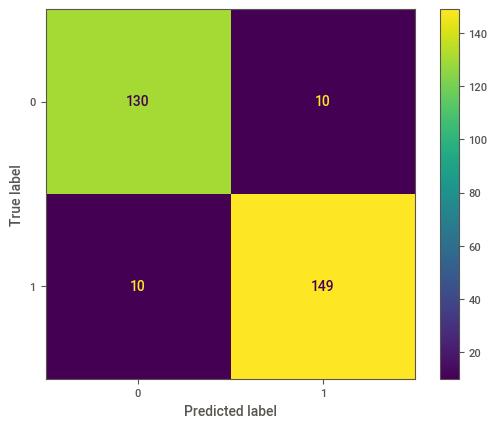

In [49]:
confusion_matrix_dps = confusion_matrix(y_test,y_pred)
display_model = ConfusionMatrixDisplay(confusion_matrix_dps)
display_model.plot()

## Treinamento Modelo - Automated Feature Selection

In [50]:
# Select Kbest - Selecionar as k melhores features, baseado em um teste

kbest = SelectKBest(score_func=chi2, k=1)

In [51]:
kbest

,score_func,<function chi...x74d82df125c0>
,k,1


In [52]:
X_train_best = kbest.fit_transform(X_train, y_train)

In [53]:
X_train_best

array([[ 82],
       [ 82],
       [ 85],
       [ 67],
       [ 82],
       [ 77],
       [ 87],
       [ 70],
       [ 82],
       [ 90],
       [ 77],
       [ 88],
       [ 72],
       [ 92],
       [ 62],
       [ 85],
       [ 68],
       [ 68],
       [ 73],
       [ 70],
       [ 87],
       [ 88],
       [ 77],
       [ 85],
       [ 92],
       [ 72],
       [ 73],
       [ 75],
       [ 85],
       [ 83],
       [ 83],
       [ 80],
       [ 70],
       [ 77],
       [ 88],
       [ 88],
       [ 73],
       [ 65],
       [ 67],
       [ 65],
       [ 72],
       [ 88],
       [ 95],
       [ 82],
       [ 88],
       [ 88],
       [ 80],
       [ 67],
       [ 72],
       [ 82],
       [ 72],
       [ 88],
       [ 80],
       [ 93],
       [ 87],
       [ 68],
       [ 82],
       [ 87],
       [ 78],
       [ 90],
       [ 63],
       [ 77],
       [ 77],
       [ 80],
       [ 75],
       [ 67],
       [ 87],
       [ 85],
       [ 83],
       [ 73],
       [ 88],
      

In [54]:
kbest_features = kbest.get_support(indices=True)
X_train_best_features = X_train.iloc[:,kbest_features]
X_train_best_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 696 entries, 753 to 102
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   pressao_arterial  696 non-null    int64
dtypes: int64(1)
memory usage: 10.9 KB


In [55]:
kbest_features

array([1])

In [56]:
# Treinar modelo com melhores features

modelo_kbest = GaussianNB()
modelo_kbest.fit(X_train_best_features,y_train)

,priors,None
,var_smoothing,1e-09


In [57]:
y_pred_best = model_baseline.predict(X_test)

classification_report_str_best = classification_report(y_test,y_pred_best)
recall_best = recall_score(y_test,y_pred_best)

print(f'Relatório de classificação: \n{classification_report_str_best}')
print(f'Recall:\n{recall_best}')

Relatório de classificação: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       140
           1       0.94      0.94      0.94       159

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299

Recall:
0.9371069182389937


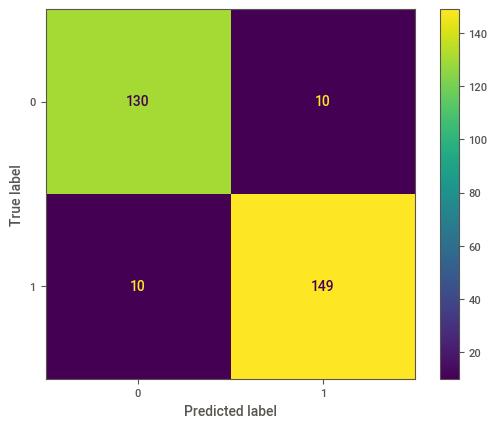

In [58]:
confusion_matrix_kbest = confusion_matrix(y_test, y_pred_best)
display_model_kbest = ConfusionMatrixDisplay(confusion_matrix_kbest)
display_model_kbest.plot()

In [59]:
import joblib

joblib.dump(modelo_kbest,'modelo_diabetes.pkl')

['modelo_diabetes.pkl']